#Predicting Google stock prices Using RNN GRU Model

This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use 'Google stock price' data to predict the number of future stock prices based on the available historical data. 

Workflow:


1.   Understanding the problem
2.   Collecting the data
3.   Data preprocessing
4.   Build Model using RNN & Grated Recurrent Unit (GRU)
5.   Training the dataset
6.   Predict 


##1. Understanding the problem
You have been given a dataset that contains google stock prices from 2013 to 2018. We have to model the time series data using RNN GRU sequential model.

Import python library

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Some functions to help out with predictions
def predictions_plot(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

##2. Collecting the Data
The dataset trainset.csv will be used for the demo. The dataset contains google stock prices from 2013 to 2018. It has been downloaded from the site https://www.kaggle.com/ptheru/google-stock-price-prediction-rnn/data 
 

Load the dataset using pandas read_csv function.

In [3]:
# First, we get the data
dataset = pd.read_csv('/content/trainset.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [4]:
# Checking for missing values in Training and Test set
training_set = dataset[:'2017'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

##Plot the data

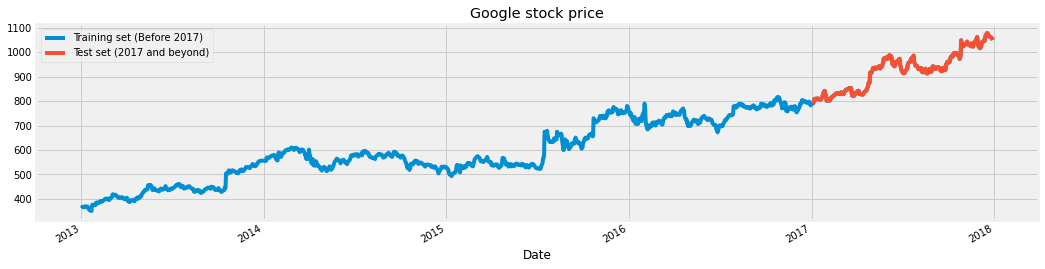

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2017'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since RNN/GRU/LSTM store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,1250):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

##Gated Recurrent Units

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

##Create the model

In [10]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [11]:
regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 60, 50)            2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 50)            5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 50)            15150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50)               

##Train the model

In [12]:
# Compiling the GRU
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
1190/1190 [==============================] - 6s 5ms/step - loss: 0.0583
Epoch 2/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0269
Epoch 3/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0191
Epoch 4/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0152
Epoch 5/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0120
Epoch 6/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0094
Epoch 7/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0084
Epoch 8/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0073
Epoch 9/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0071
Epoch 10/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0066
Epoch 11/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0057
Epoch 12/50
1190/1190 [==============================] - 4s 3ms/step - loss: 0.0060
E

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

##Test the model

In [13]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

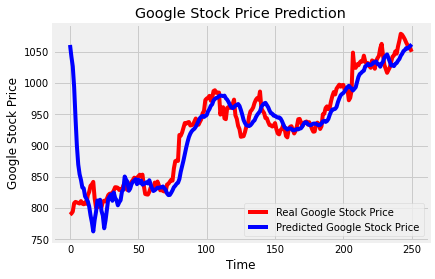

In [14]:
# Visualizing the results for GRU
predictions_plot(test_set,GRU_predicted_stock_price)

In [15]:
# Evaluating GRU
rmse_return(test_set,GRU_predicted_stock_price)

The root mean squared error is 38.03654965370535.
